In [40]:
import torch
import os
import numpy as np
import pandas as pd
from diffusers import StableDiffusionPipeline
from transformers import CLIPTokenizer, CLIPModel, CLIPProcessor, pipeline
from torch.nn import functional as F
from diffusers import StableDiffusionPipeline
from transformers import CLIPTokenizer, CLIPModel, CLIPProcessor
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from PIL import Image
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

In [36]:
# SETUP CHANGE TO WHAT YOU WANT
prompts = [
    "beautiful sunset over mountains",
    "cute cat sitting on a chair",
    "a puppy dog on the beach",
    "a bird in a nest",
    "a tall tree in a desert"
    
]
styles = ["realistic", "watercolor", 'sketch', "cartoon"]
                                                                                                              
model_CLIP = "laion/CLIP-ViT-H-14-laion2B-s32B-b79K"  # 1024-D

In [3]:
# DEVICE I'm forced CPU and cannot run float16 well :{ 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == "cuda":
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

dtype = torch.float16 if device.type == "cuda" else torch.float32 #helps prevent disk memory errors by reducing usage

In [4]:
# Standard SD pipeline
sd_pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=dtype
).to(device)

sd_pipe.enable_attention_slicing() #reduces working memory usage 
# Load CLIP for embedding comparison
clip_model = CLIPModel.from_pretrained(model_CLIP).to(device)
clip_processor = CLIPProcessor.from_pretrained(model_CLIP)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [29]:
#helper for image generation
def generate_sd_images(prompt, style, num_samples=1):
    images = []
    full_prompt = f"{prompt}, {style}"
    for i in range(num_samples):
        img = sd_pipe(full_prompt).images[0]
        images.append(img)
    return images

In [30]:
#CLIP Ranked SD -helper
def generate_clip_ranked_images(prompt, style, num_samples=4, its=50, guidance=7.5):
    full_prompt = f"{prompt}, {style}"

    inputs = clip_processor(text=[full_prompt], return_tensors="pt", padding=True).to(device)
    with torch.no_grad():
        text_emb = clip_model.get_text_features(**inputs)
        text_emb = text_emb / text_emb.norm(dim=-1, keepdim=True)

    sd_images = []
    for i in range(num_samples):
        img = sd_pipe(full_prompt, num_inference_steps=its, guidance_scale=guidance).images[0]
        sd_images.append(img)

    # Compute CLIP embeddings for each image
    img_embs = []
    for img in sd_images:
        img = img.convert("RGB") if isinstance(img, Image.Image) else img
        inputs_img = clip_processor(images=img, return_tensors="pt").to(device)
        with torch.no_grad():
            emb = clip_model.get_image_features(**inputs_img)
            emb = emb / emb.norm(dim=-1, keepdim=True)
            img_embs.append(emb.cpu())
    img_embs = torch.cat(img_embs, dim=0)

    # Compute cosine similarity to text
    sims = (img_embs @ text_emb.cpu().T).squeeze()
    best_idx = sims.argmax().item()
    return sd_images, img_embs, sims, [sd_images[best_idx]]  # return best image as list


In [31]:
def get_text_embedding(text_list):
    inputs = clip_processor(text=text_list, return_tensors="pt", padding=True).to(device)
    with torch.no_grad():
        emb = clip_model.get_text_features(**inputs)
        emb = emb / emb.norm(dim=-1, keepdim=True)
    return emb.cpu().numpy()

In [32]:
#CLIP image embeddings helper
def get_clip_embeddings(images):
    emb_list = []
    for img in images:
        img = img.convert("RGB") if isinstance(img, Image.Image) else img
        inputs = clip_processor(images=img, return_tensors="pt").to(device)
        with torch.no_grad():
            emb = clip_model.get_image_features(**inputs)
            emb = emb / emb.norm(dim=-1, keepdim=True)
            emb_list.append(emb.cpu().numpy()[0])
    return np.array(emb_list)

In [41]:
# Helper: classify styles directly from embeddings, easier to use raw metrics than eval_df
def classify(sd_metrics, clip_metrics, candidate_styles):
    X_train, y_train = [], []
    for metrics in sd_metrics + clip_metrics:
        emb_array = metrics["embeddings"]
        style = metrics["style"]
        for emb in emb_array:
            X_train.append(emb)
            y_train.append(style)
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    # Train logistic regression
    clf = LogisticRegression(max_iter=1000, multi_class='multinomial')
    clf.fit(X_train, y_train)

    # Predict styles for each method
    all_preds, all_methods, all_true_styles = [], [], []
    for metrics in sd_metrics + clip_metrics:
        emb_array = metrics["embeddings"]
        method = metrics["method"]
        style = metrics["style"]
        preds = clf.predict(emb_array)
        all_preds.extend(preds.tolist())
        all_methods.extend([method]*len(preds))
        all_true_styles.extend([style]*len(preds))
    # Create dataframe
    df = pd.DataFrame({"Method": all_methods, "True_Style": all_true_styles, "Pred_Style": all_preds})
    return df


In [10]:
# Cosine similarity helper function
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [11]:
num_samples = 4  # images per prompt/style
best_sd_images = []
best_clip_images = []
image_metadata = [] 
sd_metrics = []
clip_metrics = []

In [ ]:
for p in prompts:
    for s in styles:
        # Standard SD images: pick the first image
        full_prompt = f"{p}, {s}"
        text_emb = get_text_embedding([full_prompt])[0]

        sd_imgs = generate_sd_images(p, s, num_samples)
        sd_embs = get_clip_embeddings(sd_imgs)
        best_sd_images.append(sd_imgs[0])
        image_metadata.append({"prompt": p, "style": s, "method": "SD"})
         # Unbiased evaluation
        sd_sims = [cosine_similarity(e, text_emb) for e in sd_embs]
        sd_metrics.append({
            "prompt": p,
            "style": s,
            "method": "SD",
            "mean_similarity": np.mean(sd_sims),
            "max_similarity": np.max(sd_sims),
            "std_similarity": np.std(sd_sims),
            "embeddings": sd_embs
        })

        # CLIP-ranked images: pick best image via CLIP scoring
        all_clip_imgs, all_clip_embeds, all_clip_sims, clip_img = generate_clip_ranked_images(p, s, num_samples) #keep all_clip_imgs just in case :}
        best_clip_images.append(clip_img[0])
        image_metadata.append({"prompt": p, "style": s, "method": "CLIP-Ranked"})
        clip_metrics.append({
            "prompt": p,
            "style": s,
            "method": "CLIP-Ranked",
            "mean_similarity": all_clip_sims.mean().item(),
            "max_similarity": all_clip_sims.max().item(),
            "std_similarity": all_clip_sims.std().item(),
            "embeddings": all_clip_embeds
        })
        
all_eval = sd_metrics + clip_metrics
eval_df = pd.DataFrame(all_eval)

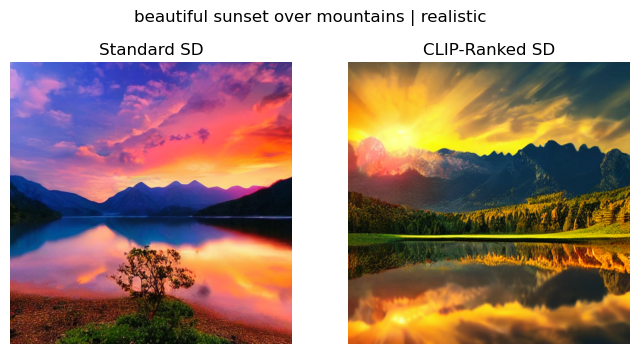

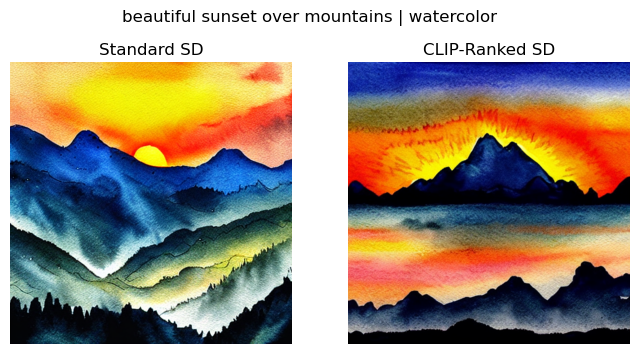

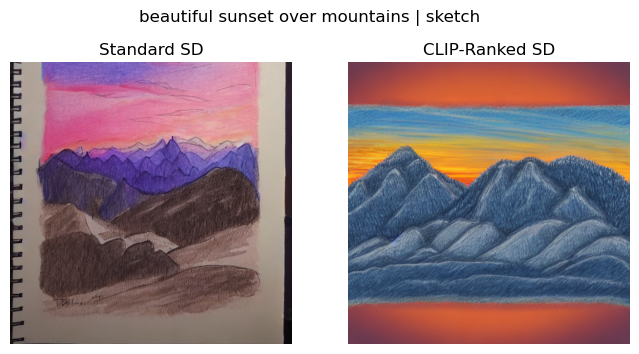

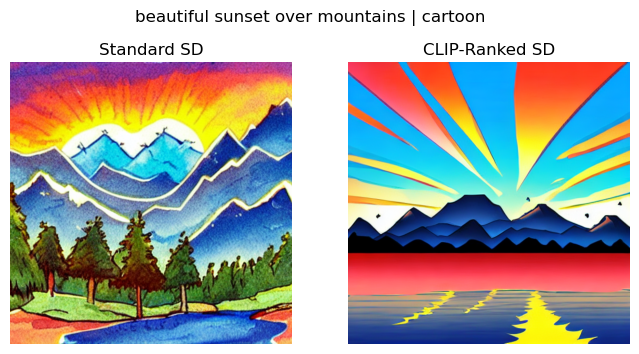

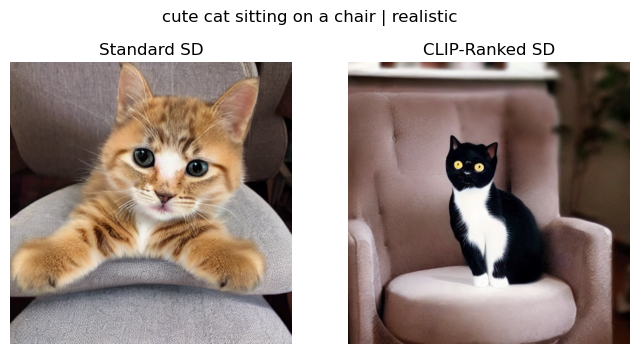

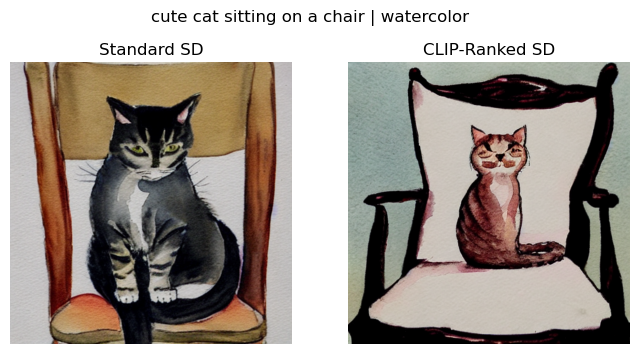

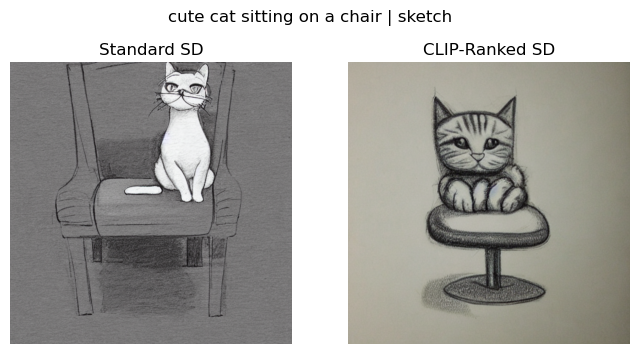

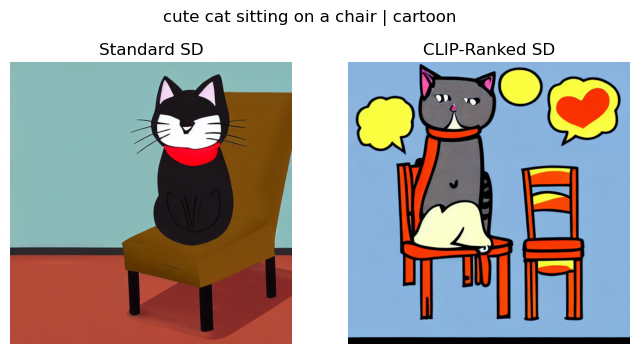

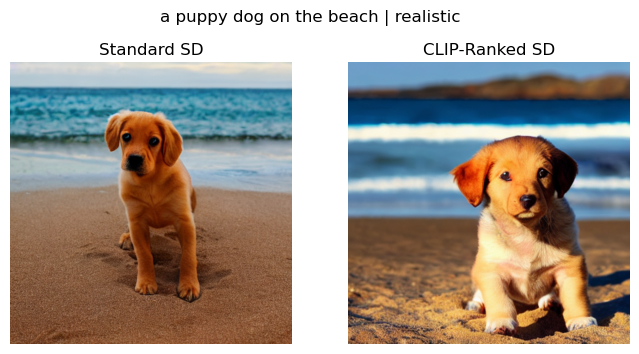

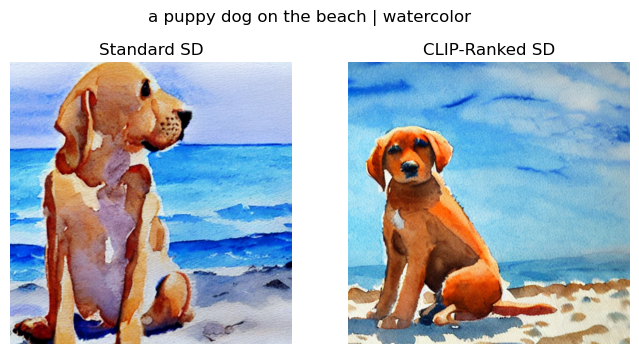

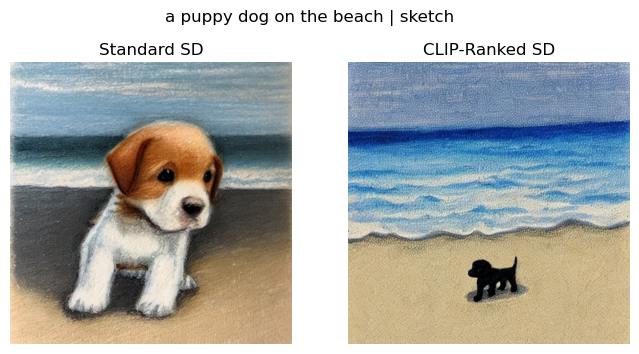

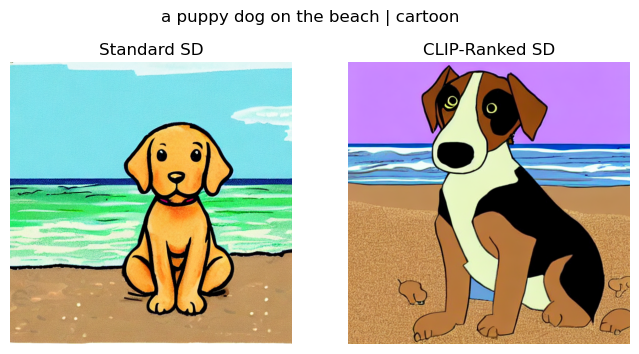

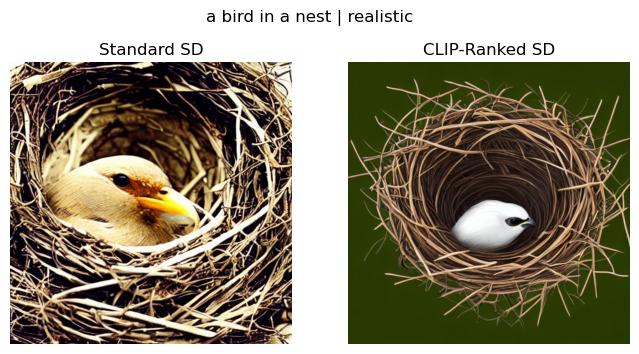

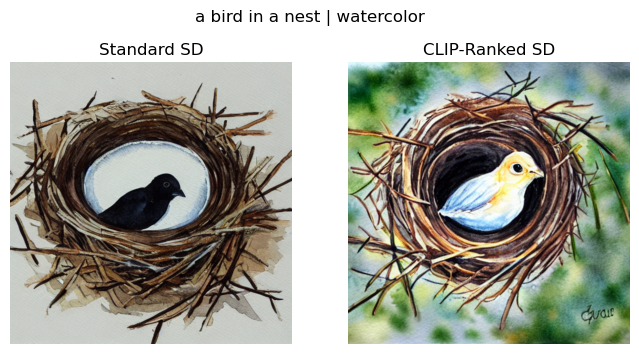

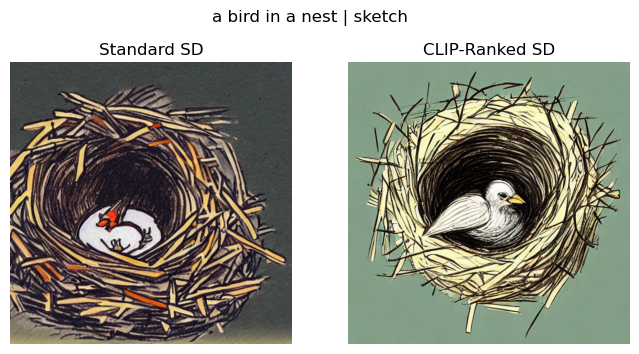

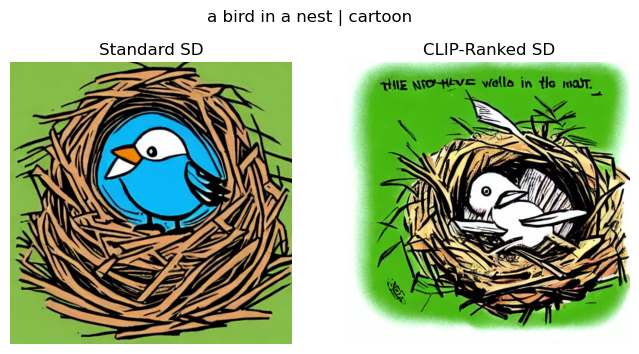

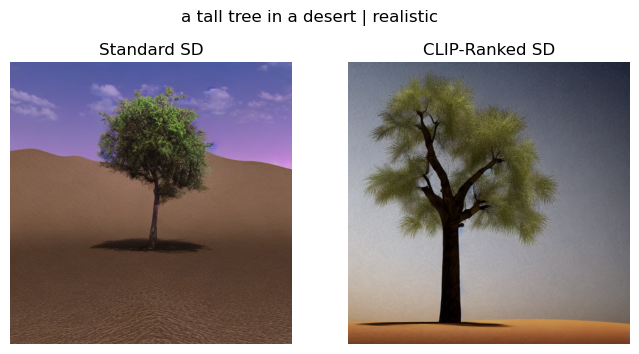

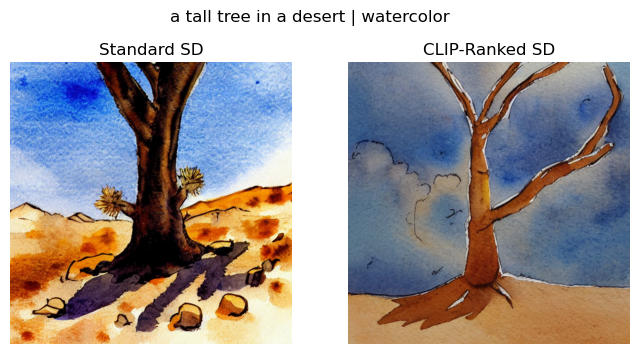

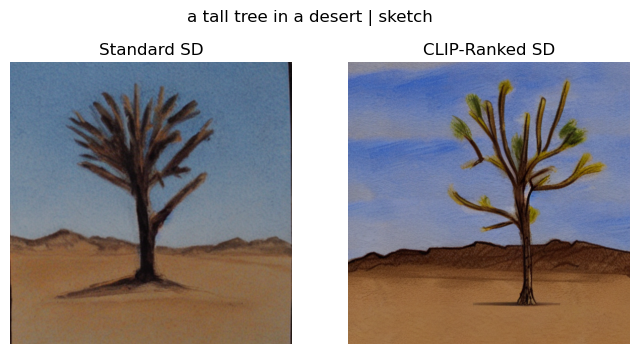

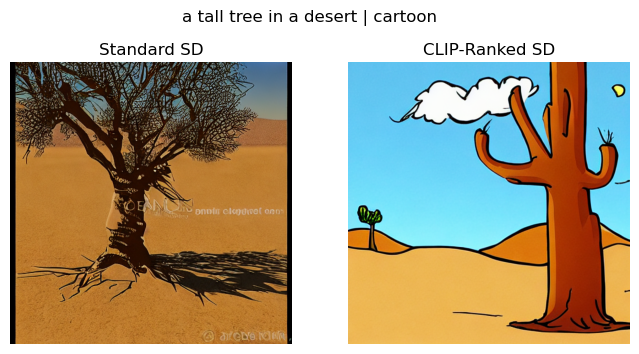

In [13]:
for i in range(len(best_sd_images)):
    plt.figure(figsize=(8, 4))
  # SD
    plt.subplot(1, 2, 1)
    plt.imshow(best_sd_images[i])
    plt.axis("off")
    plt.title("Standard SD")
  # CLIP-Rank
    plt.subplot(1, 2, 2)
    plt.imshow(best_clip_images[i])
    plt.axis("off")
    plt.title("CLIP-Ranked SD")
    plt.suptitle(image_metadata[i*2]['prompt'] + " | " + image_metadata[i*2]['style'])
    plt.show()

In [44]:
#save images for presentation:
save_dir = "COGS118B_Final_Images"
os.makedirs(save_dir, exist_ok=True)

for i in range(len(best_sd_images)):
    sd_img = best_sd_images[i]
    clip_img = best_clip_images[i]

    # Make a new image wide enough to hold both side by side
    width = sd_img.width + clip_img.width
    height = max(sd_img.height, clip_img.height)
    combined = Image.new("RGB", (width, height))

    # Paste SD and CLIP-ranked images
    combined.paste(sd_img, (0, 0))
    combined.paste(clip_img, (sd_img.width, 0))

    # Optionally, you can add a text overlay using PIL.ImageDraw to indicate which is which
    # For now, we just save
    prompt_name = image_metadata[i*2]['prompt'].replace(" ", "_")[:50]  # short name for file
    style_name = image_metadata[i*2]['style']
    filename = f"{prompt_name}_{style_name}.png"
    combined.save(os.path.join(save_dir, filename))


In [14]:
sd_embeddings_best = np.array([arr[0] for arr in eval_df[eval_df['method']=='SD']['embeddings']])
clip_embeddings_best = np.array([arr[0] for arr in eval_df[eval_df['method']=='CLIP-Ranked']['embeddings']])

# Mean cosine similarity across all samples per prompt/style
sd_mean_sims = np.array(eval_df[eval_df['method']=='SD']['mean_similarity'].tolist())
clip_mean_sims = np.array(eval_df[eval_df['method']=='CLIP-Ranked']['mean_similarity'].tolist())

num_prompts = len(prompts)
num_styles = len(styles)

sd_matrix = sd_mean_sims.reshape(num_prompts, num_styles)
clip_matrix = clip_mean_sims.reshape(num_prompts, num_styles)

difference_matrix = clip_matrix - sd_matrix

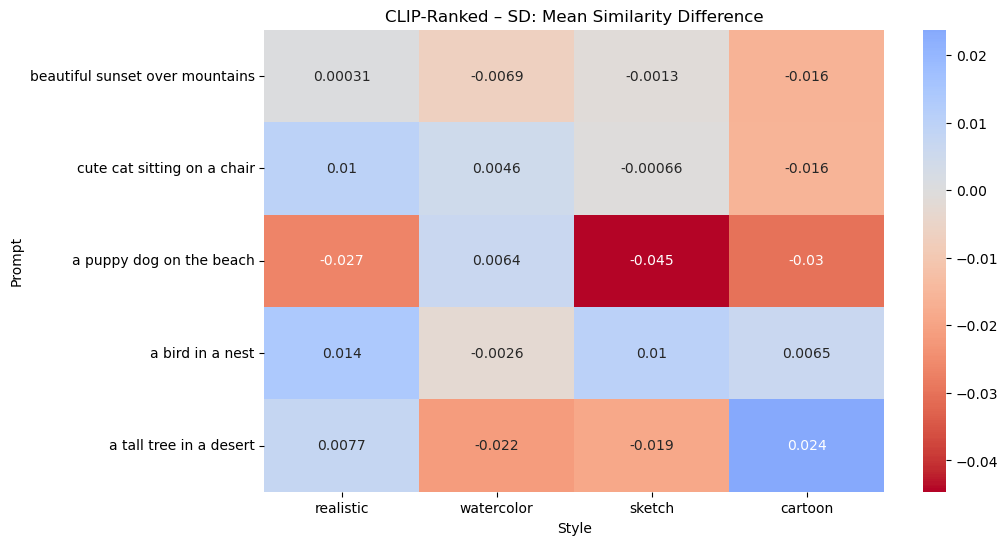

In [20]:
plt.figure(figsize=(10, 6))
sns.heatmap(difference_matrix, annot=True, xticklabels=styles, yticklabels=prompts, cmap="coolwarm_r", center=0)
plt.title("CLIP-Ranked – SD: Mean Similarity Difference")
plt.xlabel("Style")
plt.ylabel("Prompt")
plt.show()

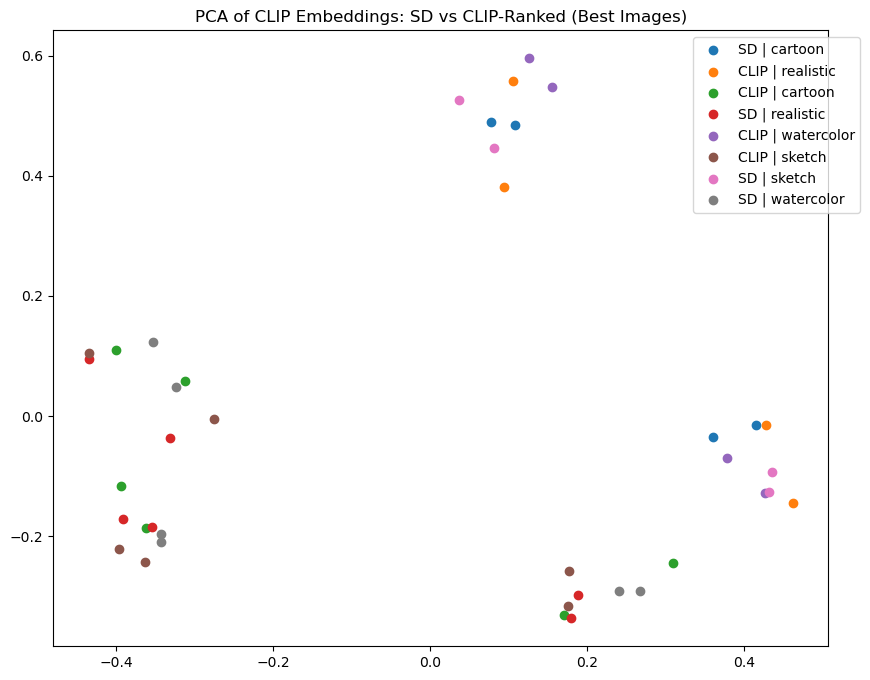

In [16]:
all_embeddings_vis = np.concatenate([sd_embeddings_best, clip_embeddings_best], axis=0)
all_labels = [f"SD | {md['style']}" for md in image_metadata[:len(best_sd_images)]] + \
             [f"CLIP | {md['style']}" for md in image_metadata[len(best_sd_images):]]

pca = PCA(n_components=2)
emb_2d = pca.fit_transform(all_embeddings_vis)
categories = list(set(all_labels))

plt.figure(figsize=(10, 8))
for c in categories:
    idxs = [i for i, l in enumerate(all_labels) if l == c]
    plt.scatter(emb_2d[idxs,0], emb_2d[idxs,1], label=c)

plt.title("PCA of CLIP Embeddings: SD vs CLIP-Ranked (Best Images)")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

In [42]:
heatplot = classify(sd_metrics, clip_metrics, candidate_styles = styles)

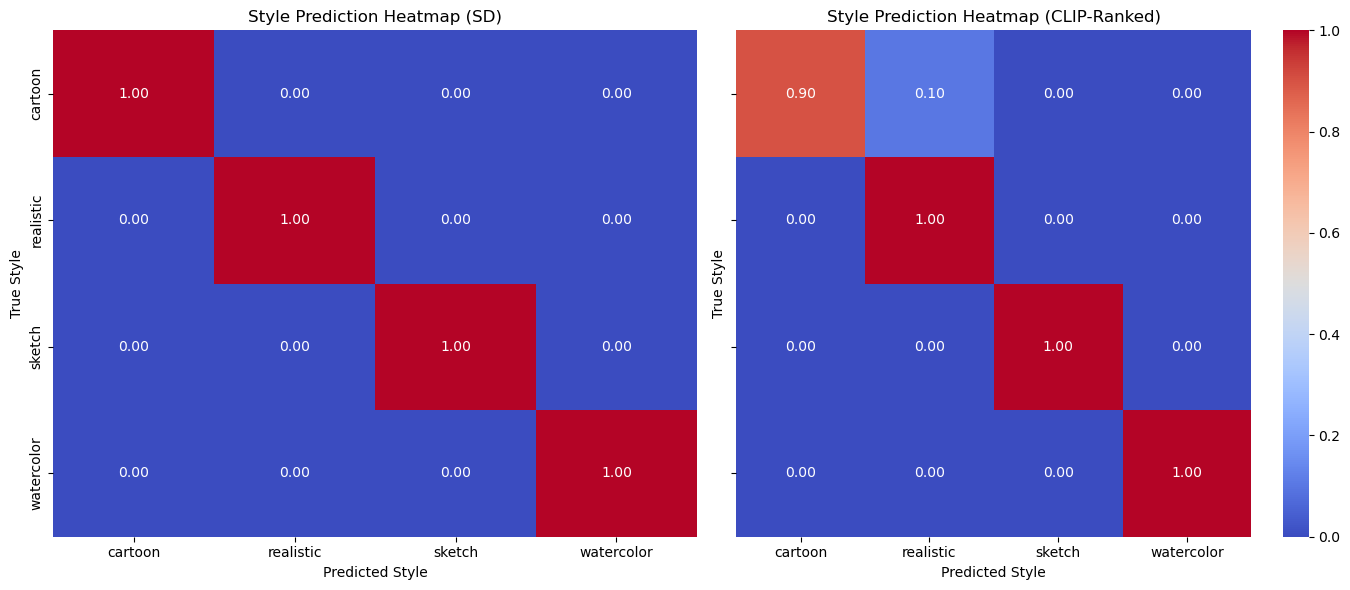

In [43]:
methods = ["SD", "CLIP-Ranked"]
fig, axes = plt.subplots(1, 2, figsize=(14,6), sharey=True)

for ax, method in zip(axes, methods):
    subset = heatplot[heatplot["Method"] == method]
    conf_mat = pd.crosstab(subset["True_Style"], subset["Pred_Style"], normalize='index')
    sns.heatmap(conf_mat, annot=True, cmap="coolwarm", fmt=".2f", ax=ax, cbar=(ax==axes[-1]))
    ax.set_title(f"Style Prediction Heatmap ({method})")
    ax.set_xlabel("Predicted Style")
    ax.set_ylabel("True Style")

plt.tight_layout()
plt.show()